In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
import sys
sys.path.append('../code')

# Load custom functions
from interpolation import cfl_interpolation5
from diusst_funcs import make_mesh
from diusst_model5 import diusst_bayesian as diusst

In [60]:
# DIUSST model
k0 = 0.8
lambd = 3
z_f = 10
dz0 = 0.10
ngrid = 40
diffu = 1
opac = 1
k_mol = 1e-7
maxwind = 10
ref_level = int(21)

data_path = '../data/bayesian_training/'
data_filename = 'training_minnett_err-boatspd-x2_humid10.csv'
data_interval1 = [96,413]
data_interval2 = [0,-1]#[1290,1585]
removeidx2 = []#[69,74,81,82,99,100,171,172,176]

In [61]:
# Load dataset
data_orig1 = pd.read_csv(data_path+data_filename)[data_interval1[0]:data_interval1[1]]

data_orig2_dirty = pd.read_csv(data_path+data_filename)[data_interval2[0]:data_interval2[1]]
data_orig2 = data_orig2_dirty.drop(data_orig2_dirty.index[removeidx2])

In [62]:
# extract data from dataset 1
ftemp1 = np.mean(data_orig1['ftemp'].to_numpy(np.float64))
times_orig1 = data_orig1['times'].to_numpy(np.float64)
sst_data1 = data_orig1['sst'].to_numpy(np.float64) - data_orig1['ftemp'].to_numpy(np.float64)
sst_err1 = data_orig1['sst_err'].to_numpy(np.float64)
# extract data from dataset 2
ftemp2 = np.mean(data_orig2['ftemp'].to_numpy(np.float64))
times_orig2 = data_orig2['times'].to_numpy(np.float64)
sst_data2 = data_orig2['sst'].to_numpy(np.float64) - data_orig2['ftemp'].to_numpy(np.float64)
sst_err2 = data_orig2['sst_err'].to_numpy(np.float64)

## insert param vals here

In [63]:
kappa, mu, attenu = [4e-5,0.006,2.2]

In [64]:
# interpolate to meet CFL condition
data1, dtlist1, idx1 = cfl_interpolation5(data_orig1, dz0=dz0, ngrid=ngrid,
        k_mol = k_mol,
        k_eddy_max=kappa, k_0_min=k0, lambd_min=lambd,
        maxwind=maxwind, z_f=z_f,
        save=None,verbose=False)

data2, dtlist2, idx2 = cfl_interpolation5(data_orig2, dz0=dz0, ngrid=ngrid,
        k_mol = k_mol,
        k_eddy_max=kappa, k_0_min=k0, lambd_min=lambd,
        maxwind=maxwind, z_f=z_f,
        save=None,verbose=False)

times1 = data1['times'].to_numpy(np.float64)
wind1 = data1['wind'].to_numpy(np.float64)
swrad1 = data1['swrad'].to_numpy(np.float64)
humid1 = data1['humid'].to_numpy(np.float64)
atemp_rel1 = data1['atemp'].to_numpy(np.float64) - data1['ftemp'].to_numpy(np.float64) + ftemp1

times2 = data2['times'].to_numpy(np.float64)
wind2 = data2['wind'].to_numpy(np.float64)
swrad2 = data2['swrad'].to_numpy(np.float64)
humid2 = data2['humid'].to_numpy(np.float64)
atemp_rel2 = data2['atemp'].to_numpy(np.float64) - data2['ftemp'].to_numpy(np.float64) + ftemp2

simu1 = diusst(
        times1, atemp_rel1, swrad1, u_data=wind1, sa_data=humid1, T_f=ftemp1,
        k_eddy=kappa, mu=mu, attenu=attenu, k_0=k0, lambd=lambd,
        opac=opac, k_mol=k_mol,
        dz=dz0, ngrid=ngrid)
simu2 = diusst(
        times2, atemp_rel2, swrad2, u_data=wind2, sa_data=humid2, T_f=ftemp2,
        k_eddy=kappa, mu=mu, attenu=attenu, k_0=k0, lambd=lambd,
        opac=opac, k_mol=k_mol,
        dz=dz0, ngrid=ngrid)

sst_model1 = simu1[:,0]-simu1[:,ref_level]
sst_model2 = simu2[:,0]-simu2[:,ref_level]

[Text(0.5, 1.0, 'SST-ftemp')]

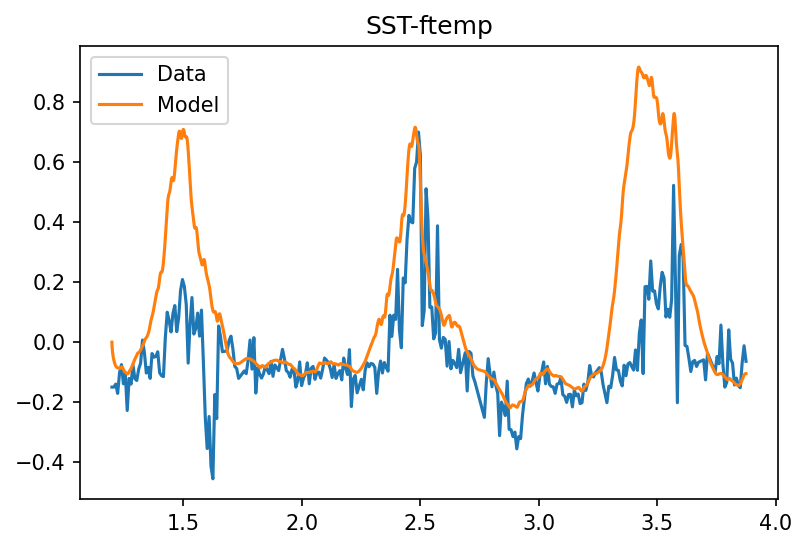

In [65]:
fig, ax = plt.subplots(dpi=150)
ax.plot(times_orig1/86400,sst_data1, label='Data')
ax.plot(times1/86400, sst_model1, label='Model')
ax.legend()
ax.set(title='SST-ftemp')

[Text(0.5, 1.0, 'SST-ftemp')]

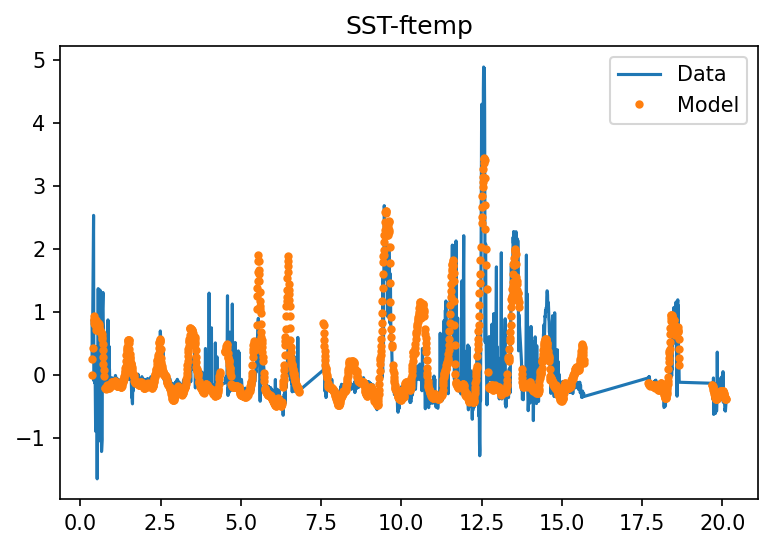

In [66]:
fig, ax = plt.subplots(dpi=150)
ax.plot(times_orig2/86400,sst_data2, label='Data')
ax.plot(times_orig2[:-1]/86400,sst_model2[idx2],'.', label='Model')
ax.legend()
ax.set(title='SST-ftemp')

## Correlation diagram

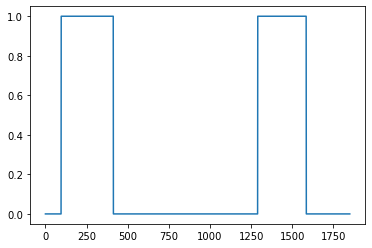

In [80]:
datatype = np.zeros(len(data_orig2)-1)
for i in range(len(datatype)):
    if i >= data_interval1[0] and i < data_interval1[1]:
        datatype[i] = 1
    elif i >= 1290 and i < 1585:
        datatype[i] = 1
plt.plot(datatype)

[[1. 1.]
 [1. 1.]]
0.7177822778455549


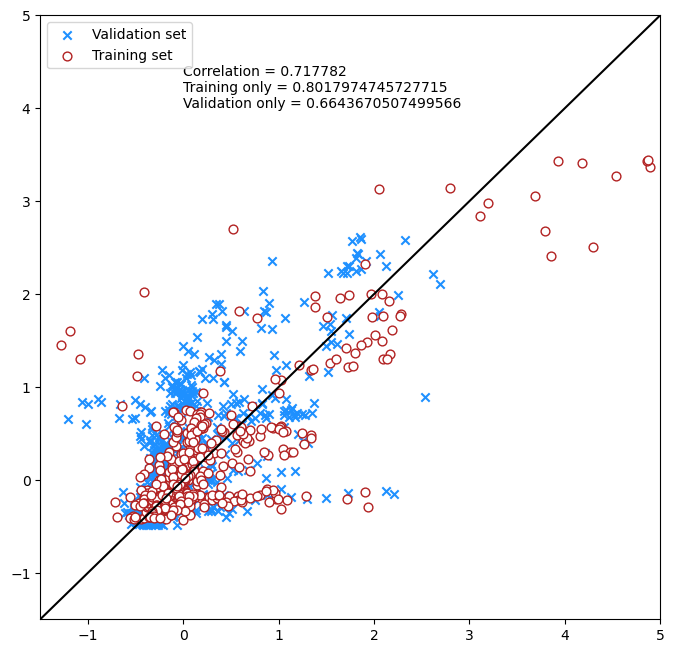

In [104]:
diag = np.linspace(-2,6,200)
corr_training = np.corrcoef(sst_data2[:-1][datatype>0.5],sst_model2[idx2][datatype>0.5])[0][1]
corr_validate = np.corrcoef(sst_data2[:-1][datatype<0.5],sst_model2[idx2][datatype<0.5])[0][1]
corr_total = np.corrcoef(sst_data2[:-1],sst_model2[idx2])[0][1]
print(np.corrcoef(times_orig2[:-1],times2[idx2]))


fig, ax = plt.subplots(dpi=100,figsize=(8,8))
ax.plot(diag,diag,c='k')
ax.scatter(sst_data2[:-1][datatype<0.5],sst_model2[idx2][datatype<0.5],marker='x',c='dodgerblue',label='Validation set')
ax.scatter(sst_data2[:-1][datatype>0.5],sst_model2[idx2][datatype>0.5],facecolors='white',s=40,edgecolors='firebrick',label='Training set')
ax.set(xlim=(-1.5,5),ylim=(-1.5,5))
ax.text(0,4,'Correlation = {:1f}\nTraining only = {}\nValidation only = {}'.format(corr_total,corr_training,corr_validate))
ax.legend()
ax.plot()

print(pearson)